# Inflation Results

# Figures:
1. dc_VS_rc : Module distance from home   versus Area radius
2. dc_VS_Areac : Module distance from home versus Area
3. dc_VS_S_num  : Module distance from home versus Unique locations-number of nodes
4. dc_VS_n_num  : Module distance from home versus Total movements-number of edges
5. dc_VS_f  :  Module distance from home versus fequency
6. module_num_distribution : Distribuiton of the number of modules

# Robustness Test
1. different countries' datasets
2. populations in different demographics
3. destinations with varying POI density
4. community detection algorithm
5. edge weights
6. data imbalance
7. COVID-19 lockdown perod


In [1]:
import pandas as pd
import os
import networkx as nx
import numpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import math
import matplotlib as mpl
import scipy
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from scipy.optimize import curve_fit
import numpy as np

def linear_fun(x, a, b):
    return a * np.asarray(x) + b

def fitting_powerlaw(x, y ,x_line,base):
    #base=10
    popt, cov = curve_fit(linear_fun, np.log(x+0.000001)/np.log(base), np.log(y+0.000001)/np.log(base))
    a, b = popt
    y_line = linear_fun(np.log(x_line+0.000001)/np.log(base), a, b)
    y_line = np.power(base, y_line)

    return a, b, x_line, y_line

def fitting_linear(x, y):
    #base=10
    popt, cov = curve_fit(linear_fun, x, y)
    a, b = popt
    y_line = linear_fun(x, a, b)

    return a, b, x, y_line

In [4]:
def set_fig_style(ax1, xlabel,ylabel,ratio):
    labelfont  = 14*ratio
    tickfont   = 14*ratio
    #tickfont   = 10*ratio
    legendfont = 14*ratio
    ax1.tick_params(axis='both', which='both', direction="in", labelsize=tickfont, pad=8 )
    for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)
    for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)

    ax1.set_xlabel(xlabel, fontsize=labelfont, labelpad=labelfont )
    ax1.set_ylabel(ylabel,fontsize=labelfont, labelpad=labelfont )
    #ax1.legend(loc='upper right', fontsize=legendfont, frameon=False)

    #ax1.spines.right.set_visible(False)
    #ax1.spines.top.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

In [5]:
US_region_dict={'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont',
                              'New Jersey','New York','Pennsylvania'],
                'Midwest':['llinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin','Iowa','Kansas','Minnesota',
                          'Missouri','Nebraska','North Dakota','South Dakota'],
                'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 
                          'Virginia', 'Washington, D.C.',  'West Virginia','Alabama', 'Kentucky', 'Mississippi',
                           'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
                'West':['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming',
                        'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']}

# Figures

In [33]:
def dc_VS_rc(df_list,label_list,dis_r,show_fitting,path_figure):
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))
    base=10
    for df, label_str, show  in zip(df_list, label_list, show_fitting):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
      
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+1)/0.2)*0.2), df_data['d_home']))
        df_data1 = df_data.groupby(['d_home'])['radius'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['radius'].std().reset_index()
        df_data1 = df_data1[(df_data1['d_home'] >0) & (df_data1['d_home'] <= dis_r)]
        
        if dis_r>1000:
            end_dots=len(df_data1)
        else:
            end_dots=-1
        if show == True:
            x_line = np.arange(dis_r)
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][1:end_dots], df_data1['radius'][1:end_dots], x_line,
                                                          base=base)

            ax.scatter(df_data1['d_home'], df_data1['radius'], s=50, marker='o', color='black', label=label_str,zorder=1)
            #ax.scatter(df_data1['d_home'], df_data1['radius'], s=20, marker='o', color='black', label=label_str,zorder=1)

            ax.plot(xline, yline, '-',color='r',alpha=0.25,linewidth=5, zorder=0, label=r'${r_c}\sim {d_c}^{%s}$'%round(a1,2))
            print('slope',a1,b1)
        else:
            x_line = np.arange(dis_r)
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][2:-2], df_data1['radius'][2:-2], x_line,
                                                          base=base)
            print('slope',a1,b1)
            ax.scatter(df_data1['d_home'], df_data1['radius'], s=50, marker='o' ,label=label_str)
            
        ax.set_xlim(1, dis_r*1.1)
        #sprint(np.min(yline), np.max(yline))
        ax.set_ylim(1, np.max(yline)*1.1)

    xs=np.log10(df_data1['d_home'][1:-1])
    ys=np.log10(df_data1['radius'][1:-1])
    xs = sm.add_constant( xs )
    model = sm.OLS( ys, xs )
    results = model.fit()
    print('confidence interval',results.conf_int( alpha=0.1 ))

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Module radius (km), '+ r'$r_c$',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    ax.set_yscale('log')  #
    
    #import matplotlib as mpl
    
    mpl.rcParams['pdf.fonttype']=42
    plt.savefig(path_figure,bbox_inches='tight',dpi=600)
    return a1

    

In [85]:
def dc_VS_Areac(df_list,label_list,dis_r,show_fitting,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))

    for df, label_str, show  in zip(df_list, label_list,show_fitting):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+0.5)/0.2)*0.2), df_data['d_home']))
        df_data1 = df_data.groupby(['d_home'])['area'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['area'].std().reset_index()
        if show == True:
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][2:-2], df_data1['area'][2:-2],  np.arange(1,dis_r),
                                                          base=base)
            
            ax.scatter(df_data1['d_home'], df_data1['area'], s=50, marker='o', color='black', label=label_str,zorder=1)
            ax.plot(xline, yline, '-',linewidth=5,alpha=0.25,color='#e41a1c',zorder=0, label=r'${A_c}\sim {d_c}^{%s}$'%round(a1,2))
            
            print('slope',a1,b1)
        else:
          ax.scatter(df_data1['d_home'], df_data1['area'], s=40, marker='o', label=label_str)
        
        ax.set_xlim(1, dis_r)
        #ax.set_ylim(np.min(yline), np.max(yline)*1.1)

    

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Convex hull area size, '+ r'$A_c$',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    ax.set_yscale('log')  #
    #ax.set_ylim(0.1,20)
    plt.tight_layout()
    fig.savefig(path_figures, dpi=600)

In [12]:
def dc_VS_S_num(df_list,label_list,dis_r,show_fitting,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))

    for df, label_str, show  in zip(df_list, label_list,show_fitting):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+0.5)/0.2)*0.2), df_data['d_home']))
      
        df_data1 = df_data.groupby(['d_home'])['#unique_loc'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['#unique_loc'].std().reset_index()
        
        if show == True:
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][2:-2], df_data1['#unique_loc'][2:-2],  np.arange(1,dis_r),
                                                          base=base)

            ax.scatter(df_data1['d_home'], df_data1['#unique_loc'], s=40, marker='o', color='black', label=label_str,zorder=1)
            #ax.plot(xline, yline, '-',color='#e41a1c',alpha=0.5,linewidth=2, zorder=0, label='slope='+str(round(a1,2)))
            print('slope',a1,b1)
        else:
            ax.scatter(df_data1['d_home'], df_data1['#unique_loc'], s=40, marker='o', color=color, label=label_str)
        
        
        ax.set_xlim(1, dis_r)
        ax.set_ylim(np.min(yline), np.max(yline))
       
    

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Locations within module',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    #ax.set_yscale('log')  #
    #ax.set_ylim(5,15)
    ax.set_ylim(0,20)
    plt.tight_layout()
    fig.savefig(path_figures, dpi=600)

In [13]:
def dc_VS_n_num(df_list,label_list,dis_r,show_fitting,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))

    for df, label_str, show  in zip(df_list, label_list,show_fitting):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+0.5)/0.2)*0.2), df_data['d_home']))
        df_data1 = df_data.groupby(['d_home'])['#move'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['#move'].std().reset_index()
        if show == True:
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][2:-2], df_data1['#move'][2:-2],  np.arange(1,dis_r),
                                                          base=base)

            ax.scatter(df_data1['d_home'], df_data1['#move'], s=40, marker='o', color='black', label=label_str,zorder=1)
            #ax.plot(xline, yline, '-',color='#e41a1c',alpha=0.5,linewidth=2, zorder=0, label='slope='+str(round(a1,2)))
            print('slope',a1,b1)
        else:
            ax.scatter(df_data1['d_home'], df_data1['#move'], s=40, marker='o', color=color, label=label_str)
        
        ax.set_xlim(1, dis_r)
        ax.set_ylim(np.min(yline), np.max(yline))

    

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Travels within modules',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    #ax.set_yscale('log')  #
    ax.set_ylim(10,60)
    plt.tight_layout()
    fig.savefig(path_figures, dpi=600)

In [14]:
def dc_VS_f(df_list,label_list,dis_r,show_fitting,path_figures):
    base=10
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))

    for df, label_str, show  in zip(df_list, label_list,show_fitting):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+0.5)/0.2)*0.2), df_data['d_home']))
        df_data1 = df_data.groupby(['d_home'])['frequency'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['frequency'].std().reset_index()
        if show == True:
            a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][5:-2], df_data1['frequency'][5:-2],  np.arange(1,dis_r),
                                                          base=base)

            ax.scatter(df_data1['d_home'], df_data1['frequency'], s=40, marker='o', color='black', label=label_str,zorder=1)
            ax.plot(xline, yline, '-',color='#e41a1c',alpha=0.4,linewidth=4, zorder=0, label='slope='+str(round(a1,2)))
            print('slope',a1,b1)
        else:
            ax.scatter(df_data1['d_home'], df_data1['frequency'], s=40, marker='o', color=color, label=label_str)
        
        ax.set_xlim(1, 4000)
        ax.set_ylim(np.min(yline), np.max(yline))

    

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Visit frequency (module)',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    ax.set_yscale('log')  #
    ax.set_ylim(1,20)
    plt.tight_layout()
    fig.savefig(path_figures, dpi=600)

In [15]:
def module_num_distribution(df_list,label_list,dis_r,show_fitting,path_figures):
    base=10
    fig, ax1 = plt.subplots(1, 1, figsize=(4.5, 3.7))
    marker_list=np.array(['o','^','s','<','>','*','+'])
    color_list=np.array(['#325db3','#878787','#a2212a','#4daf4a'])
    default_marker=zip(marker_list,color_list)
    for df_temp, label_str, m, show in zip(df_list, label_list, default_marker, show_fitting):
        (marker, color) = m
        
        df_tempx=df_temp.groupby(['id'])['cluster'].count().reset_index()
       
        count, bins_count = np.histogram(df_temp['cluster'], bins=100)
        bins_count = np.array([(bins_count[i] + bins_count[i + 1]) / 2 for i in np.arange(len(bins_count) - 1)])
        pdf = count / np.sum(count)

        #ax1.scatter(bins_count, pdf, color='black',marker=marker, zorder=1, s=20,label=label_str)
       
        sns.kdeplot(df_tempx['cluster'] , shade=True,bw_adjust=5,log_scale=True,ax=ax1)
        ax1.axvline(np.mean(df_tempx['cluster']),color='k')
        
        print('module_num',np.mean(df_tempx['cluster']))
    set_fig_style(ax1, 'Number of modules, '+r'$N_c$',r'$P(N_c)$',1)

    ax1.legend(loc='lower left', fontsize=12, frameon=False)
    #ax1.set_yscale('log')
    #ax1.set_xscale('log')
    #ax1.set_xlim(1, dis_r)
    #ax1.set_ylim(0.0001, 1)
    plt.tight_layout()
    fig.savefig(path_figures, dpi=600)

# Cuebiq US data

In [18]:
raw_path='/Volumes/SeagateDrive/Mobility_Project/'

df = pd.read_csv(raw_path+'Cuebiq_data_results/all_usr_community.csv')

df_covid_0 = df[df['covid'] == 0]
df_covid_1 = df[df['covid'] == 1]

print('cuebiq data load done')

cuebiq data load done


In [19]:
raw_path='/Volumes/SeagateDrive/Mobility_Project/'
df_home = pd.read_csv(raw_path+'Cuebiq_data_results/all_usr_home_sum(with_county).csv')

Northeast
891181
slope 0.6299948699750286 -0.007800740002233519
confidence interval                0         1
const  -0.236346  0.015708
d_home  0.610653  0.737209
Midwest
2206708
slope 0.6120699104130299 0.0583770863582556
confidence interval                0         1
const  -0.199929  0.099415
d_home  0.583478  0.733777
South
6249340
slope 0.5795943698614858 0.09050500817229151
confidence interval                0         1
const  -0.145945  0.103785
d_home  0.564722  0.690111
West
1404240
slope 0.6235006828953127 0.03605685148456428
confidence interval                0         1
const  -0.180859  0.052080
d_home  0.608070  0.725028


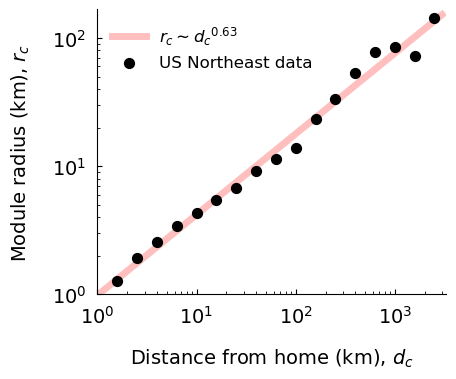

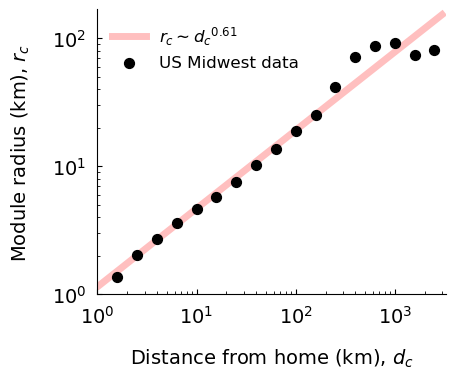

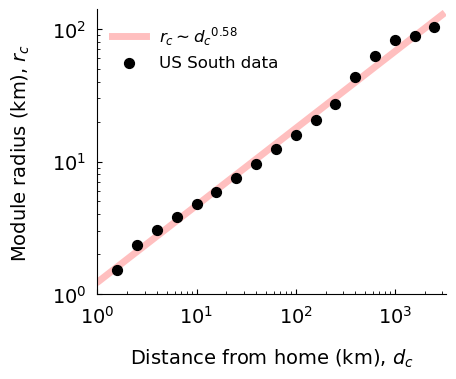

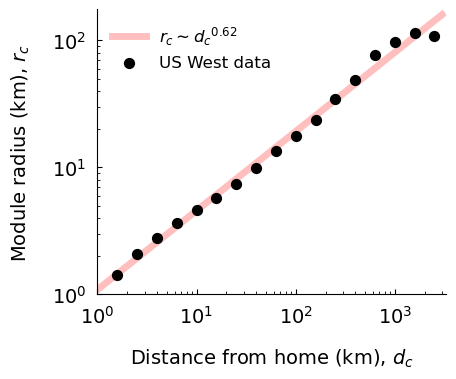

In [32]:
case='US-all'
case='US-state'
case='US-region'

if case=='US-all':
    
    path_figures_cuebiq='Results/Results_cuebiq/Inflation/'

    dc_VS_rc([df],['US data'],3000,[True],path_figures_cuebiq+ 'd_r.png')
    '''
    dc_VS_Areac([df],['US data'],3000,[True],path_figures_cuebiq+ 'd_Area_community.png')

    dc_VS_S_num([df],['US data'],3000,[True],path_figures_cuebiq+ 'd_S_community.png')

    dc_VS_n_num([df],['US data'],3000,[True],path_figures_cuebiq+ 'd_n_community.png')
    dc_VS_f([df],['US data'],3000,[True],path_figures_cuebiq+ 'd_f_community.png')
    module_num_distribution([df],['US data'],3000,[True],path_figures_cuebiq+ 'module_num_distribution.png')
    '''
if case=='US-state':
    path_figures_cuebiq='Results/Results_cuebiq/Inflation/States/'

    ouput_exponent=[]
    for state, df_temp in df_home.groupby('state'):
        print(state)
        state=state+' data'
        id_list=list(df_temp['id'])
        dfx=df[df['id'].isin(id_list)]
        if len(dfx)>100:
            print(len(dfx))
            exponent=dc_VS_rc([dfx],[state],1000,[True],path_figures_cuebiq+ 'd_r_'+state+'.png')
            #dc_VS_Areac([dfx],[state],1000,[True],path_figures_cuebiq+ 'd_Area_community'+state+'.png')
            ouput_exponent.append(exponent)

if case=='US-region': 
    path_figures_cuebiq='Results/Results_cuebiq/Inflation/Regions/'

    for region, state_list in US_region_dict.items():
        print(region)
        region='US '+region+' data'
        id_list=list(df_home[df_home['state'].isin(state_list)]['id'])
        dfx=df[df['id'].isin(id_list)]
        
        df_list=[dfx]
        label_list=[region]
        show_fitting=[True]
        
        r=3000

        if len(dfx)>1000:
            print(len(dfx))
            dc_VS_rc(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'd_r_'+region+'.pdf')
            '''
            dc_VS_Areac(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'd_Area_community'+region+'.png')
            

            dc_VS_S_num(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'd_S_community'+region+'.png')

            dc_VS_n_num(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'd_n_community'+region+'.png')
            dc_VS_f(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'd_f_community'+region+'.png')
            module_num_distribution(df_list,label_list,r,show_fitting,path_figures_cuebiq+ 'module_num_distribution'+region+'.png')
            '''
            

In [29]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    print(h)
    return m, m-h, m+h

ouput_exponent=list(ouput_exponent)+list([0.62,0.63,0.58,0.61,0.58,0.58])
print(mean_confidence_interval([0.62,0.63,0.58,0.61]))
print(mean_confidence_interval(ouput_exponent))

0.03437434881858911
(0.61, 0.5756256511814108, 0.6443743488185891)
0.0242142384376284
(0.6226210009739576, 0.5984067625363292, 0.6468352394115859)


# Senegal Data

In [15]:

df=pd.read_csv('Results/Results_Senegal/results_cluster_log_weight_Louvain_save.csv')
            
print('Senegal data load done')


Senegal data load done


slope 0.5821860851592842 -0.05936571812382563


"\ndc_VS_Areac(df_list,label_list,200,show_fitting,path_figures_senegal+ 'd_Area_community.png')\n\ndc_VS_S_num(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_S_community.png')\n\ndc_VS_n_num(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_n_community.png')\ndc_VS_f(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_f_community.png')\n\nmodule_num_distribution(df_list,label_list,600,show_fitting,path_figures_senegal+ 'module_num_distribution.png')\n"

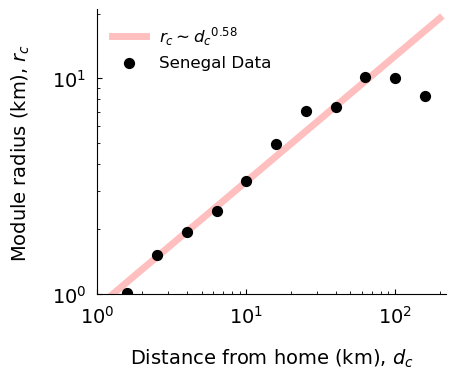

In [16]:
path_figures_senegal='Results/Results_senegal/Inflation/'

df_list=[df]
label_list=['Senegal Data']
show_fitting=[True]

dc_VS_rc(df_list,label_list,200,show_fitting,path_figures_senegal+ 'd_r_community.pdf')
#dc_VS_rc_population(df_list,label_list,rgc_dict,1100,show_fitting,path_figures_cuebiq+ 'd_r_community.png')

'''
dc_VS_Areac(df_list,label_list,200,show_fitting,path_figures_senegal+ 'd_Area_community.png')

dc_VS_S_num(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_S_community.png')

dc_VS_n_num(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_n_community.png')
dc_VS_f(df_list,label_list,600,show_fitting,path_figures_senegal+ 'd_f_community.png')

module_num_distribution(df_list,label_list,600,show_fitting,path_figures_senegal+ 'module_num_distribution.png')
'''

# Ivory data

slope 0.5838237687828411 -0.012313877322130962


"\ndc_VS_Areac(df_list,label_list,300,show_fitting,path_figures_ivory+ 'd_Area_community.png')\n\n\ndc_VS_S_num(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_S_community.png')\n\ndc_VS_n_num(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_n_community.png')\ndc_VS_f(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_f_community.png')\n\nmodule_num_distribution(df_list,label_list,600,show_fitting,path_figures_ivory+ 'module_num_distribution.png')\n"

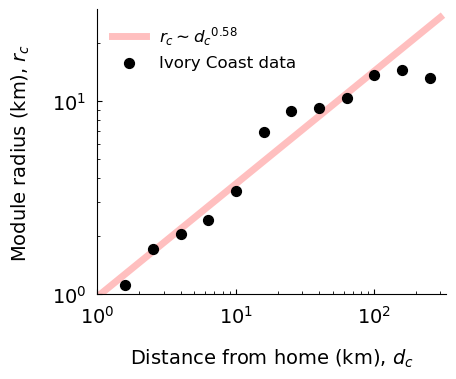

In [17]:
####Ivory data
path_figures_ivory='Results/Results_ivory/Inflation/'

df=pd.read_csv('Results/Results_ivory/results_cluster_log_weight_Louvain_save.csv')

df_list=[df]
label_list=['Ivory Coast data']
show_fitting=[True]

dc_VS_rc(df_list,label_list,300,[True],path_figures_ivory+ 'd_r_Ivory.pdf')
'''
dc_VS_Areac(df_list,label_list,300,show_fitting,path_figures_ivory+ 'd_Area_community.png')


dc_VS_S_num(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_S_community.png')

dc_VS_n_num(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_n_community.png')
dc_VS_f(df_list,label_list,600,show_fitting,path_figures_ivory+ 'd_f_community.png')

module_num_distribution(df_list,label_list,600,show_fitting,path_figures_ivory+ 'module_num_distribution.png')
'''

# Roubstness Test---varying demographics

In [55]:
def dc_VS_rc_subgroup(df_data,dis_r,strx,templist,templabel,path_figure):
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
    base=10
    slope_list=[]
    df_data = df_data[(df_data['d_home'] >= 1) & (df_data['d_home'] <= dis_r)]
    df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x)/0.2)*0.2), df_data['d_home']))
    df_data['count']=np.arange(len(df_data))
    #df_temp = df_data.groupby(['d_home'])['count'].sum().reset_index()
    #df_data1=df_data1[df_data1['count']>100]
    color_list=['#feedde','#fdbe85','#fd8d3c','#d94701']
    color_list=['#e41a1c', '#377eb8','#0f947e']
    for value1,value2,color,labelx in zip(templist[0:-1],templist[1:len(templist)],color_list,templabel):
           
        df_temp=df_data[(df_data[strx]>=value1)&(df_data[strx]<value2)]
        print(len(df_temp))
        df_temp_mean=df_temp.groupby(['d_home'])['radius'].mean().reset_index()
        df_temp_std=df_temp.groupby(['d_home'])['radius'].std().reset_index()
        df_temp['count']=[1]*len(df_temp)
        df_temp_count=df_temp.groupby(['d_home'])['count'].sum().reset_index()
        
        df_temp_std['radius']=scipy.stats.t.ppf((1 + 0.95) / 2., df_temp_count['count']-1)
        #ax.scatter(df_temp_mean['d_home'], df_temp_mean['radius'], s=40,color=color, marker='o', label=labelx)
        ax.errorbar(df_temp_mean['d_home'], df_temp_mean['radius'],yerr=df_temp_std['radius'],fmt='-o',alpha=0.5,color=color, marker='o', label=labelx)
        a1, b1, xline, yline = fitting_powerlaw(df_temp['d_home'][0:-2], df_temp['radius'][0:-2], np.arange(4000),
                                                          base=base)

    ax.set_ylim(2, 100)
    ax.set_xlim(1, dis_r*1.1)
    
    
    set_fig_style(ax,'Distance from home (km), '+r'$d_c$','Module radius (km), '+r'$r_c$',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    ax.set_yscale('log')  #

    plt.tight_layout()
    fig.savefig(path_figure+'dc_VS_rc'+strx+'.png', dpi=600)

[2.499, 30.722600000000007, 116.833, 250.001]
=======strx_type median_income
135266
1489802
137591
[0.0, 0.06184012066365008, 0.2886762360446571, 1.0]
=======strx_type older65
141837
1476247
191897
[0.0, 0.43902439024390244, 0.5827241702379298, 1.0]
=======strx_type Female
168877
1506090
134765
[0.010005558643690939, 0.01768935805405939, 0.6468131925028476, 1.0]
=======strx_type Black
117211
912364
62250
[0.0, 0.016859000587570273, 0.34517766497461927, 1.0]
=======strx_type percentpoor
157763
1510651
135707


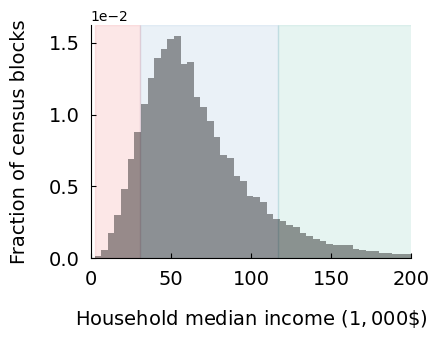

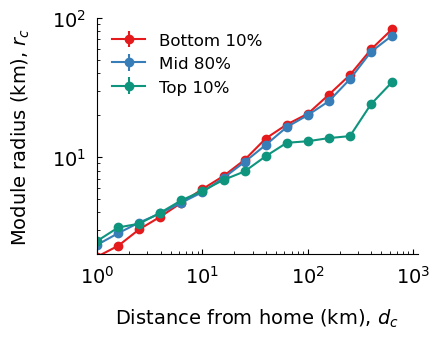

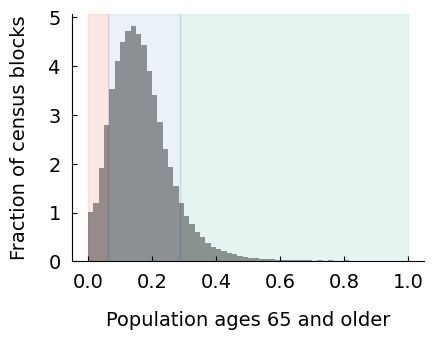

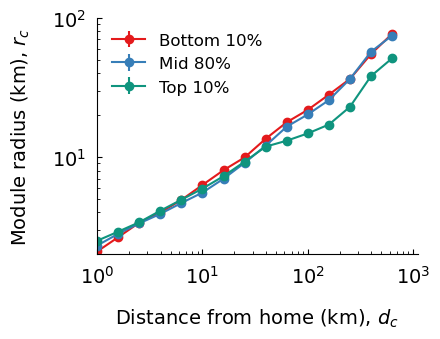

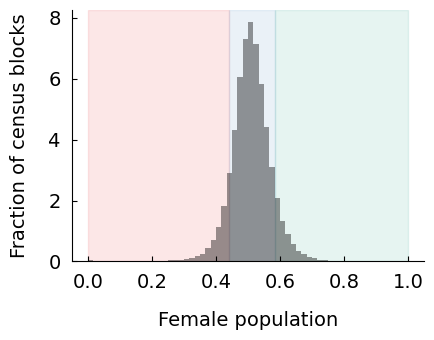

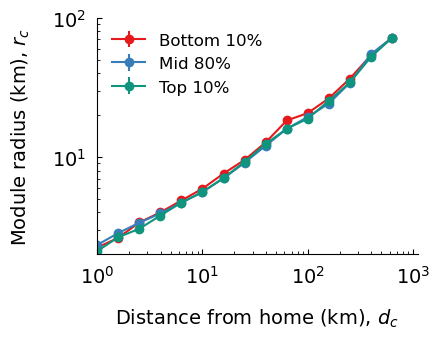

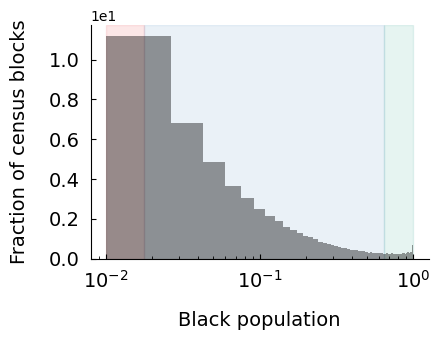

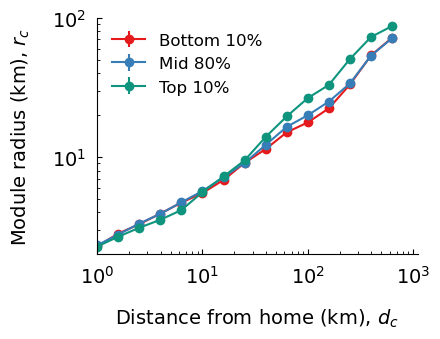

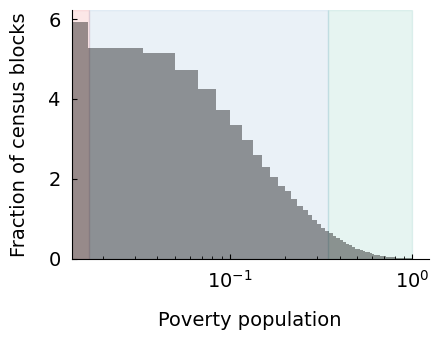

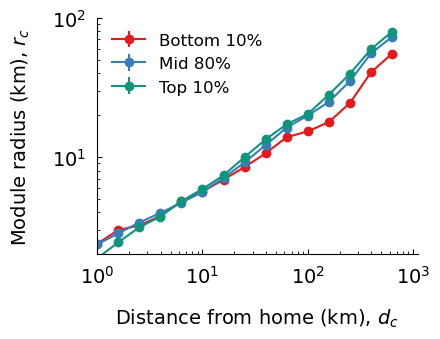

In [32]:
####home location demogrpahics

demographic_list=['median_income','older65','Female','Black','percentpoor']

for demo in demographic_list:

    if demo=='median_income':
        df_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/ACS_achieve_data/data/cbg_b19.csv')
        df_block['newblock']=df_block['census_block_group'].astype(int)
        df_block['median_income'] = df_block['B19013e1']
        df_block['median_income']=df_block['median_income']/1000

    if demo=='percentpoor':
        df_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/ACS_achieve_data/data/cbg_c17.csv')
        df_block['newblock']=df_block['census_block_group'].astype(int)
        df_block['percentpoor'] = (df_block['C17002e2']+df_block['C17002e3'])/df_block['C17002e1']

    if demo=='older65':
        df_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/ACS_achieve_data/data/cbg_b01.csv')
        df_block['newblock']=df_block['census_block_group'].astype(int)
        df_block['children']=(df_block['B01001e3']+df_block['B01001e4']+df_block['B01001e5']+df_block['B01001e27']+df_block['B01001e28']+df_block['B01001e29'])/df_block['B01001e1']

        df_block['older65']=(df_block['B01001e20']+df_block['B01001e21']+df_block['B01001e22']+df_block['B01001e23']+df_block['B01001e24']+df_block['B01001e25']
                           +df_block['B01001e44']+df_block['B01001e45']+df_block['B01001e46']+df_block['B01001e47']+df_block['B01001e48']+df_block['B01001e49'])/df_block['B01001e1']

    if demo=='Female':  

        df_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/ACS_achieve_data/data/cbg_b01.csv')
        df_block['newblock']=df_block['census_block_group'].astype(int)
        df_block['Female']=df_block['B01001e26']/df_block['B01001e1']

    if demo=='Black':     

        df_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/ACS_achieve_data/data/cbg_b03.csv')
        df_block['newblock']=df_block['census_block_group'].astype(int)

        df_block['Black'] = df_block['B03002e4']/df_block['B03002e1']
        df_block=df_block[df_block['Black']>0.01]


    fig, ax1 = plt.subplots(1, 1, figsize=(4.5, 3.5))

    color_list=['#000000','#e41a1c', '#377eb8','#0f947e']

    quantile_value=[df_block[demo].quantile(v) for v in [0,1/10,9/10,1]] 
    print(quantile_value)
    ax1.axvspan(quantile_value[0], quantile_value[1], alpha=0.1,color='#e41a1c')
    ax1.axvspan(quantile_value[1], quantile_value[2], alpha=0.1,color='#377eb8')
    ax1.axvspan(quantile_value[2], quantile_value[3], alpha=0.1,color='#0f947e')
    sns.distplot(df_block[demo],kde=False,bins=60,norm_hist=True,color='#000000',ax=ax1)

    if demo=='median_income':

        set_fig_style(ax1, 'Household median income '+'('+r'$1,000\$$'+')', 'Fraction of census blocks',1)
        median_income_quantile_value=quantile_value
        ax1.set_xlim(0,200)

    if demo=='older65':

        set_fig_style(ax1, 'Population ages 65 and older', 'Fraction of census blocks',1)

    if demo=='Female':
        set_fig_style(ax1, 'Female population', 'Fraction of census blocks',1)

    if demo=='Black':
        set_fig_style(ax1, 'Black population', 'Fraction of census blocks',1)
        #ax1.set_xlim(0.001,1)
        ax1.set_xscale('log')

    if demo=='percentpoor':
        set_fig_style(ax1, 'Poverty population', 'Fraction of census blocks',1)
        ax1.set_xscale('log')

    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0.0001))
    plt.tight_layout()
    fig.savefig('Results/Results_cuebiq/robustness_test_demographic/distribution_block_'+demo+'.png',dpi=600)

    
    df_home=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/all_usr_home_sum(with_block).csv')
    df_cuebiq_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/all_usr_community(with_block).csv')
    df_cuebiq_block = df_cuebiq_block[df_cuebiq_block['covid'] == 0]

    print('=======strx_type',demo)
    quantile_value=[df_block[demo].quantile(v) for v in [0,1/10,9/10,1]] 

    df_block['GEOID']=df_block['census_block_group']
    df_home_update=df_home.merge(df_block[['GEOID',demo]],on=['GEOID'],how='left')
    df_merge=df_cuebiq_block.merge(df_home_update[['id','GEOID','state',demo]],on=['id'],how='left')

    quantile_label=['Bottom 10%','Mid 80%','Top 10%']
    dc_VS_rc_subgroup(df_merge,1000,demo,quantile_value,quantile_label,'Results/Results_cuebiq/robustness_test_demographic/')


# Roubstness Test---varying urban features-POI

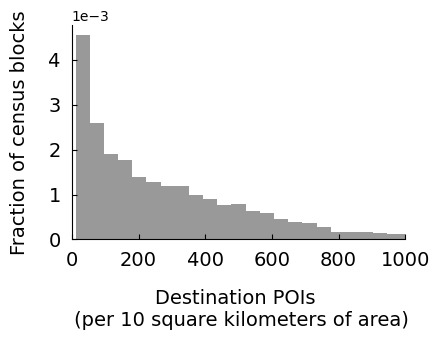

In [6]:
#######load block buffer POI counts
rootdir = '/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/block_POIs_different_buffers/'

df_block_POI_buffer=[]
for file in os.listdir(rootdir):
    df = pd.read_csv(rootdir + file)
    df_block_POI_buffer.append(df)

df_block_POI_buffer=pd.concat(df_block_POI_buffer)



POI_type='POI_count10'
fig, ax1 = plt.subplots(1, 1, figsize=(4.5, 3.5))
df_temp=df_block_POI_buffer[df_block_POI_buffer[POI_type]>10]

quantile_value=[df_temp[POI_type].quantile(v) for v in [0,1/10,9/10,1]] 
'''
ax1.axvspan(quantile_value[0], quantile_value[1], alpha=0.1,color='#e41a1c')
ax1.axvspan(quantile_value[1], quantile_value[2], alpha=0.1,color='#377eb8')
ax1.axvspan(quantile_value[2], quantile_value[3], alpha=0.1,color='#0f947e')
'''
sns.distplot(df_temp[POI_type],kde=False,bins=50,norm_hist=True,color='#000000',ax=ax1)

POI_quantile_value=quantile_value

set_fig_style(ax1, 'Destination POIs \n (per 10 square kilometers of area)', 'Fraction of census blocks',1)
ax1.set_xlim(0,1000)
#ax1.set_ylim(0,0.01)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0.0001))
plt.tight_layout()
fig.savefig('Results/Results_cuebiq/robustness_test_POI/distribution_'+POI_type+'.png',dpi=600)

In [7]:
df_home=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/all_usr_home_sum(with_block).csv')
df_cuebiq_block=pd.read_csv('/Volumes/SeagateDrive/Mobility_Project/Cuebiq_data_results/all_usr_community(with_block).csv')
df_cuebiq_block = df_cuebiq_block[df_cuebiq_block['covid'] == 0]


df_merge=df_cuebiq_block.merge(df_block_POI_buffer,on=['GEOID'],how='left')

quantile_label=['Bottom 10%','Mid 80%','Top 10%']
dc_VS_rc_subgroup(df_merge,1000,POI_type,quantile_value,quantile_label,'Results/Results_cuebiq/robustness_test_POI/')

NameError: name 'dc_VS_rc_subgroup' is not defined

In [8]:
print(df_merge.columns)

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'cluster',
       '#loc', '#record', 'radius', 'area', 'stay_t', 'frequency', 'd_home',
       'center', 'bearing', 'covid', 'center_lat', 'center_lon', 'GEOID',
       'Unnamed: 0_y', 'POI_count10', 'block_count10', 'GEOID.1',
       'POI_count30', 'block_count30', 'GEOID.2', 'POI_count50',
       'block_count50', 'GEOID.3', 'POI_count100', 'block_count100',
       'POI_count1', 'block_count1'],
      dtype='object')


         d_home   count
0      1.000000  107245
1      1.584893  129029
2      2.511886  161498
3      3.981072  200277
4      6.309573  237347
5     10.000000  263553
6     15.848932  262539
7     25.118864  230761
8     39.810717  187444
9     63.095734  164966
10   100.000000  180492
11   158.489319  201075
12   251.188643  203904
13   398.107171  178315
14   630.957344  177495
15  1000.000000  170417
16  1584.893192  127204
17  2511.886432   29777


No handles with labels found to put in legend.


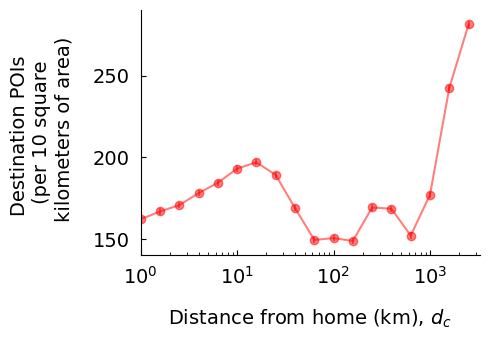

In [39]:
df_data=df_merge
dis_r=3000

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
base=10
slope_list=[]
df_data = df_data[(df_data['d_home'] >= 1) & (df_data['d_home'] <= dis_r)]
df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x)/0.2)*0.2), df_data['d_home']))
df_data['count']=np.arange(len(df_data))
#df_temp = df_data.groupby(['d_home'])['count'].sum().reset_index()
#df_data1=df_data1[df_data1['count']>100]
color_list=['#feedde','#fdbe85','#fd8d3c','#d94701']
color_list=['#e41a1c', '#377eb8','#0f947e']

df_temp=df_data

df_temp_mean=df_temp.groupby(['d_home'])['POI_count10'].mean().reset_index()
df_temp_std=df_temp.groupby(['d_home'])['POI_count10'].std().reset_index()
df_temp['count']=[1]*len(df_temp)
df_temp_count=df_temp.groupby(['d_home'])['count'].sum().reset_index()
print(df_temp_count)

df_temp_std['POI_count10']=scipy.stats.t.ppf((1 + 0.95) / 2., df_temp_count['count']-1)
#ax.scatter(df_temp_mean['d_home'], df_temp_mean['radius'], s=40,color=color, marker='o', label=labelx)
ax.errorbar(df_temp_mean['d_home'], df_temp_mean['POI_count10'],yerr=df_temp_std['POI_count10'],fmt='-o',alpha=0.5,color='red', marker='o', label='')
a1, b1, xline, yline = fitting_powerlaw(df_temp['d_home'][0:-2], df_temp['radius'][0:-2], np.arange(4000),
                                                  base=base)

#ax.set_ylim(2, 100)
ax.set_xlim(1, dis_r*1.1)


set_fig_style(ax,'Distance from home (km), '+r'$d_c$','Destination POIs \n (per 10 square \n kilometers of area)',1)
ax.legend(loc='upper left', fontsize=12, frameon=False)
ax.set_xscale('log')  #
#ax.set_yscale('log')  #

plt.tight_layout()
fig.savefig('Results/Results_cuebiq/robustness_test_POI/dc_VS_POI_count10.png', dpi=600)

# Roubstness Test---varying weights

slope 0.5870754281726938 0.38647789164474744
slope 0.6038155491436966 0.40543859398257404
slope 0.13007300390508675 0.30144009270003064


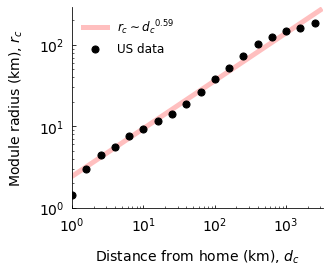

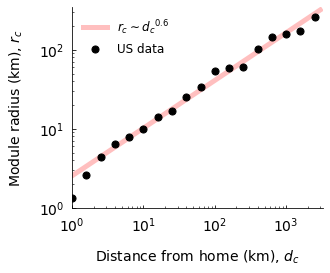

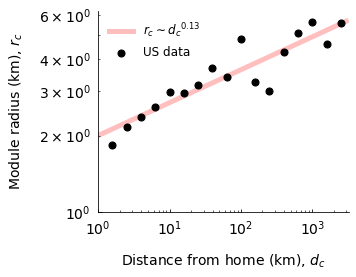

In [43]:
path_cuebiq='Results/Results_cuebiq/'

df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Modular.csv')
df2=pd.read_csv(path_cuebiq+'results_cluster_no_log_weight_Modular.csv')
df3=pd.read_csv(path_cuebiq+'results_cluster_no_log_weight_reciprocal_Modular.csv')


dc_VS_rc([df1],['US data'],3000,[True],path_cuebiq+ 'd_r(log_weight).png')
dc_VS_rc([df2],['US data'],3000,[True],path_cuebiq+ 'd_r(no_log_weight).png')
dc_VS_rc([df3],['US data'],3000,[True],path_cuebiq+ 'd_r(no_log_weight_reciprocal).png')


# Roubstness Test---varying clustering method

In [66]:
def dc_VS_rc_compare(df_list,label_list,dis_r,show_fitting,path_figure):
    color_list=['black','#d7191c','#2c7bb6']
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))
    base=10
    for df, label_str, show, color  in zip(df_list, label_list, show_fitting,color_list):
        df_data = copy.deepcopy(df)
        
        df_data = df_data[(df_data['d_home'] >0) & (df_data['d_home'] <= dis_r)]
      
        df_data['d_home'] = list(map(lambda x: math.pow(base, int(math.log10(x+1)/0.2)*0.2), df_data['d_home']))
        df_data1 = df_data.groupby(['d_home'])['radius'].mean().reset_index()
        df_data1_std = df_data.groupby(['d_home'])['radius'].std().reset_index()
        df_data1 = df_data1[(df_data1['d_home'] >0) & (df_data1['d_home'] <= dis_r)]
        
        if dis_r>1000:
            end_dots=len(df_data1)
        else:
            end_dots=-1

        x_line = np.arange(dis_r)
        a1, b1, xline, yline = fitting_powerlaw(df_data1['d_home'][1:end_dots], df_data1['radius'][1:end_dots], x_line,
                                                      base=base)

        ax.plot(xline, yline, '-',color=color,alpha=0.25,linewidth=5, zorder=0)
        
        labelx=r'$~~({r_c}\sim {d_c}^{%s})$'%round(a1,2)
        
        ax.scatter(df_data1['d_home'], df_data1['radius'], s=50, marker='o', color=color, alpha=0.5,label=label_str+labelx,zorder=1)
        

        ax.set_xlim(1, dis_r*1.1)
        #sprint(np.min(yline), np.max(yline))
        ax.set_ylim(1, 10000)

    

    set_fig_style(ax, 'Distance from home (km), '+r'$d_c$','Module radius (km), '+ r'$r_c$',1)
    ax.legend(loc='upper left', fontsize=12, frameon=False)
    ax.set_xscale('log')  #
    ax.set_yscale('log')  #
    
    #import matplotlib as mpl
    mpl.rcParams['pdf.fonttype']=42
    plt.savefig(path_figure,bbox_inches='tight',dpi=600)

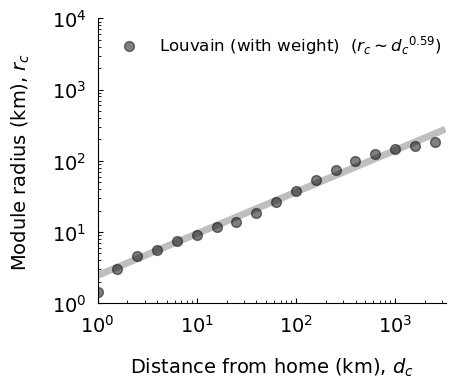

In [72]:
path_cuebiq='Results/Results_cuebiq/robustness_test_community/'
df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Louvain.csv')

dc_VS_rc_compare([df1],['Louvain (with weight)'],3000,[True,True],path_cuebiq+ 'd_r(Louvain).png')

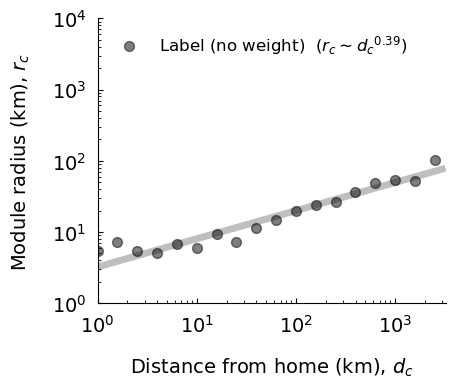

In [73]:

df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Label.csv')
dc_VS_rc_compare([df1],['Label (no weight)'],3000,[True,True],path_cuebiq+ 'd_r(Label).png')

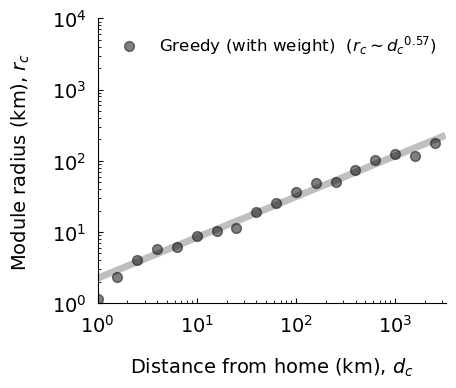

In [74]:

df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Naive.csv')
dc_VS_rc_compare([df1],['Greedy (with weight)'],3000,[True,True],path_cuebiq+ 'd_r(Naive).png')

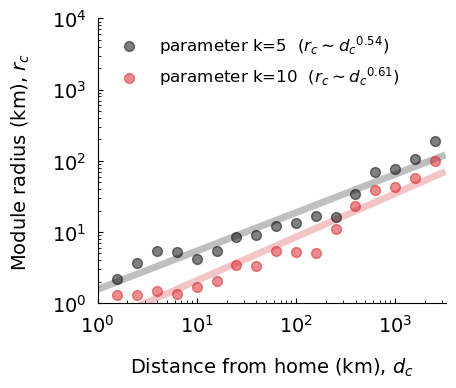

In [76]:
####Hiercichal
df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Hierarchical_5.csv')
df2=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Hierarchical_10.csv')


dc_VS_rc_compare([df1,df2],['parameter k=5','parameter k=10'],3000,[False,False],path_cuebiq+ 'd_r(Hierarchical).png')

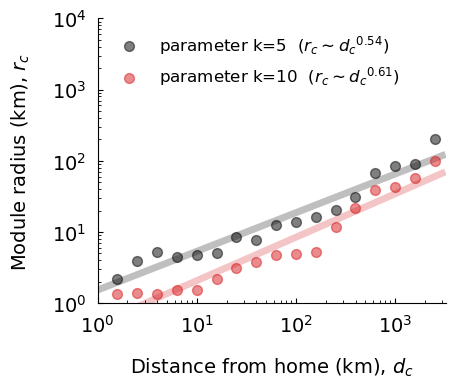

In [77]:
####Kmeans
df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Kmeans_5.csv')
df2=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Kmeans_10.csv')


dc_VS_rc_compare([df1,df2],['parameter k=5','parameter k=10'],3000,[False,False],path_cuebiq+ 'd_r(Kmeans).png')

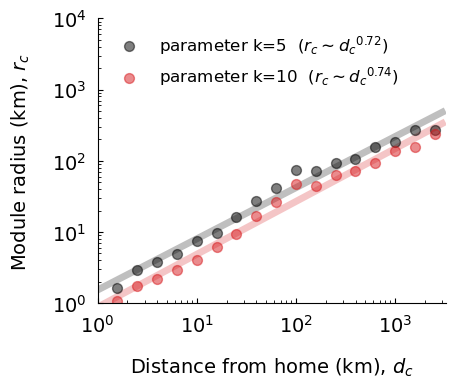

In [78]:
####Kmeans
df1=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Kmedoids_5.csv')
df2=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Kmedoids_10.csv')


dc_VS_rc_compare([df1,df2],['parameter k=5','parameter k=10'],3000,[False,False],path_cuebiq+ 'd_r(Kmedoids).png')

# Roubstness Test---Downsampling

In [79]:
def running_mean(x, N):
    #print(x)
    newlist=[np.mean(x[0:i+1])  if i<=N else np.mean(x[i-N:i]) for i in np.arange(len(x))]
    #print(newlist)
    return newlist


0.045262073023189214
    d_home      prob  new_prob_1  new_prob_2
0     10.0  0.474055    0.237027    0.020000
1     20.0  0.136168    0.068084    0.020000
2     30.0  0.103804    0.051902    0.020000
3     40.0  0.094712    0.047356    0.020000
4     50.0  0.065208    0.032604    0.020000
..     ...       ...         ...         ...
95   960.0  0.040882    0.040882    0.040882
96   970.0  0.020728    0.020728    0.020728
97   980.0  0.032530    0.032530    0.032530
98   990.0  0.023090    0.023090    0.023090
99  1000.0  0.018222    0.018222    0.018222

[100 rows x 4 columns]


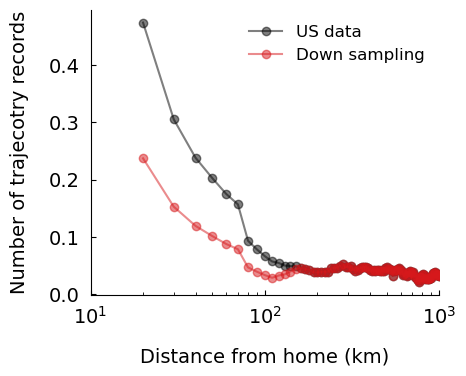

In [80]:
#####
color_list=['black','#d7191c','#2c7bb6']

path_cuebiq='Results/Results_cuebiq/robustness_test_down_sampling/'
df1=pd.read_csv(path_cuebiq+'d_home_number_record.csv')

df1=df1.groupby(['d_home'])['prob'].mean().reset_index()
df1=df1[df1['d_home']<=1000]

print(df1['prob'].mean())
df1['new_prob_1']=list(map(lambda x: x[1]/2 if x[0]<100 else x[1], zip(df1['d_home'],df1['prob'])))
df1['new_prob_2']=list(map(lambda x: 0.02 if x[0]<100 else x[1], zip(df1['d_home'],df1['prob'])))


fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.7))
ax.plot(df1['d_home']+10,running_mean(df1['prob'],5), marker='o',color=color_list[0],alpha=0.5,label='US data')  
ax.plot(df1['d_home']+10,running_mean(df1['new_prob_1'],5), marker='o',color=color_list[1],alpha=0.5, label='Down sampling')  
#ax.plot(df1['d_home']+10,running_mean(df1['new_prob_2'],5), marker='o',color=color_list[2],alpha=0.5, label='Down sampling-2')  

print(df1)
set_fig_style(ax, 'Distance from home (km)' ,'Number of trajecotry records',1)
ax.legend(loc='upper right', fontsize=12,frameon=False)
ax.set_xscale('log')  #
ax.set_xlim(10,1000)
plt.savefig(path_cuebiq+'d_home_number_record.png',bbox_inches='tight',dpi=600)

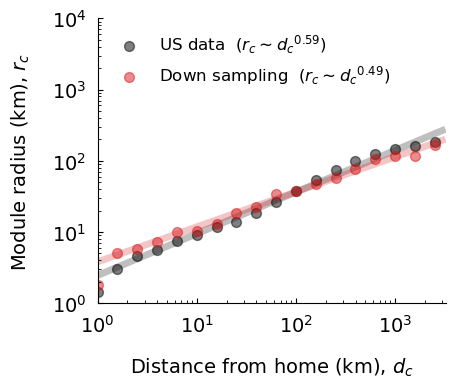

In [81]:

path_cuebiq='Results/Results_cuebiq/robustness_test_down_sampling/'
df1=pd.read_csv('Results/Results_cuebiq/results_cluster_log_weight_Louvain.csv')
df2=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Louvain_down_sampling_1.csv')
df3=pd.read_csv(path_cuebiq+'results_cluster_log_weight_Louvain_down_sampling_2.csv')

dc_VS_rc_compare([df1,df2],['US data','Down sampling'],3000,[False,False,False],path_cuebiq+ 'd_r(down_sampling).png')


# Roustness Test---COVID-19 period

In [82]:
raw_path='/Volumes/SeagateDrive/Mobility_Project/'

df = pd.read_csv(raw_path+'Cuebiq_data_results/all_usr_community.csv')

Northeast
891181
slope 0.587946835284163 -0.05671676137280279
slope 0.6709633630584348 -0.005157151976183494
slope 0.5639838373884813 -1.2315523437930174
Midwest
891181
slope 0.5915799716427014 -0.017770529365130683
slope 0.6761494986869243 0.026391963716228095
slope 0.6168381556446789 -1.2575550128398887
South
891181
slope 0.5623427890284948 0.010181400263939544
slope 0.58858830371279 0.12941151745132715
slope 0.5358900971489827 -1.1945700125332854
West
891181
slope 0.6001655843181576 -0.02467521679968001
slope 0.653523596655099 0.04453811516892159
slope 0.5685078929448388 -1.1993147044046961


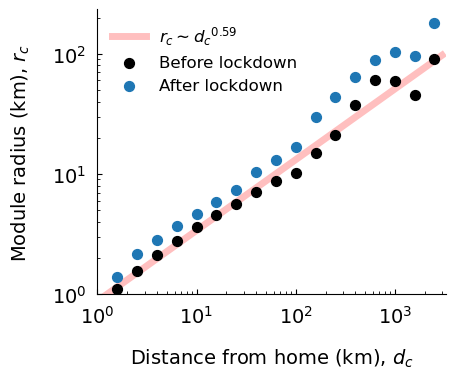

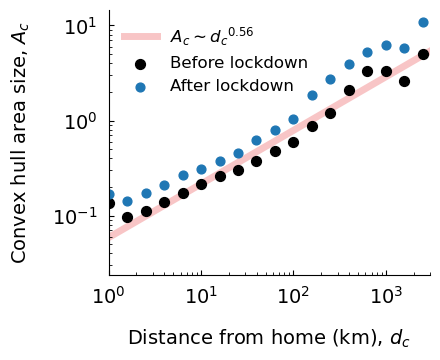

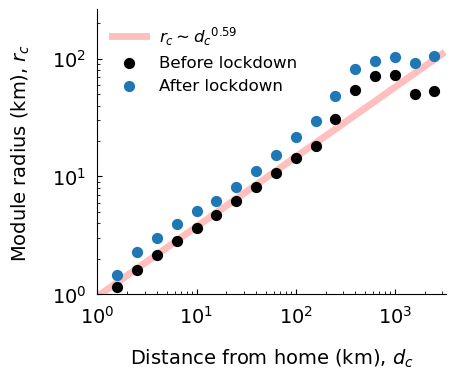

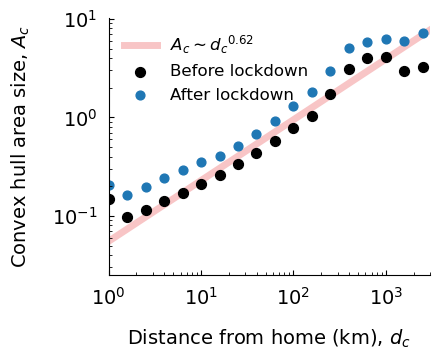

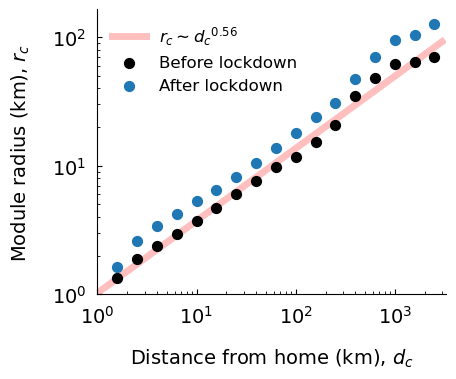

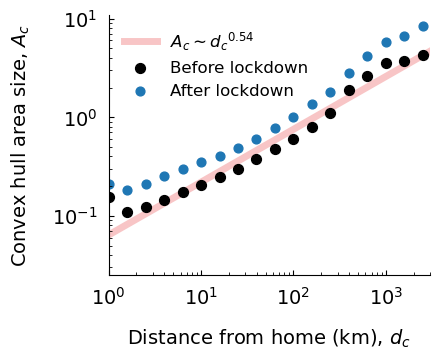

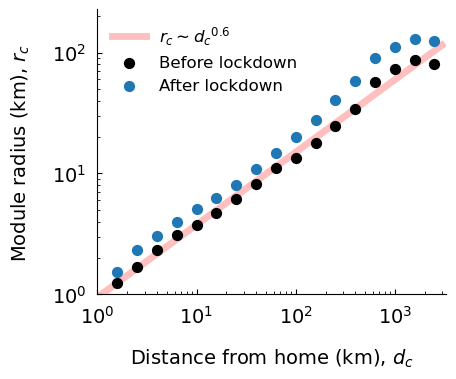

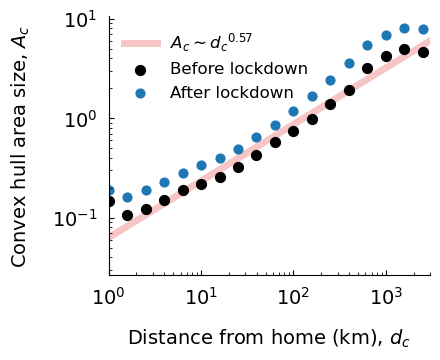

In [86]:

path_cuebiq='Results/Results_cuebiq/robustness_test_covid/'
df1 = df[df['covid'] == 0]
df2 = df[df['covid'] ==1]


for region, state_list in US_region_dict.items():
    print(region)
    region='US '+region+' data'
    id_list=list(df_home[df_home['state'].isin(state_list)]['id'])
    df1_x=df1[df1['id'].isin(id_list)]
    df2_x=df2[df2['id'].isin(id_list)]

    df_list=[df1_x,df2_x ]
    label_list=['Before lockdown','After lockdown']
    show_fitting=[True,False]
    
    if len(dfx)>100:
        print(len(dfx))
        dc_VS_rc(df_list,label_list,3000,show_fitting,path_cuebiq+ 'd_r_covid'+region+'.png')
        dc_VS_Areac(df_list,label_list,3000,show_fitting,path_cuebiq+ 'd_Area_community_covid'+region+'.png')

